In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [335]:
ls_returns = pd.read_pickle("long_short_returns.pkl")
interest_rates = pd.read_csv("FEDFUNDS.csv", parse_dates=['observation_date'], index_col='observation_date')
gdp = pd.read_csv("GDPC1.csv", parse_dates=['observation_date'], index_col='observation_date')
vix = pd.read_csv("VIXCLS.csv", parse_dates=['observation_date'], index_col='observation_date')
inflation = pd.read_csv("INFLATION.csv", parse_dates=["observation_date"], index_col="observation_date")
consumer_sentiment = pd.read_csv("UMCSENT.csv", parse_dates=["observation_date"], index_col="observation_date")
credit_spread = pd.read_csv("BAA10Y.csv", parse_dates=['observation_date'], index_col='observation_date')
TB = pd.read_csv("DTB3.csv", parse_dates=['observation_date'], index_col='observation_date')
LGB = pd.read_csv("LGB.csv", parse_dates=['observation_date'], index_col='observation_date')
industrial_production = pd.read_csv("INDPRO.csv", parse_dates=['observation_date'], index_col='observation_date')
consumption = pd.read_csv("PCE.csv", parse_dates=['observation_date'], index_col='observation_date')
oil_prices = pd.read_csv("WPU0561.csv", parse_dates=['observation_date'], index_col='observation_date')
baa = pd.read_csv("BAA.csv", parse_dates=['observation_date'], index_col='observation_date')
TB = TB/100
inflation = inflation/100
baa = baa/100
LGB = LGB/100


interest_rates.rename(columns={"FEDFUNDS": "Interest_Rate"}, inplace=True)
gdp.rename(columns={"GDPC1": "Growth"}, inplace=True)
vix.rename(columns={"VIXCLS": "VIX"}, inplace=True)
inflation.rename(columns={"FPCPITOTLZGUSA": "Inflation"}, inplace=True)
#cpi = inflation_yearly.resample('M').ffill()
consumer_sentiment.rename(columns={"UMCSENT" : "Consumer_Sentiment"}, inplace=True)
credit_spread.rename(columns={"BAA10Y" : "Credit_Spread"}, inplace=True)
TB.rename(columns={"DTB3" : "Treasury Bill"}, inplace=True)
TB_shift = TB.shift(1)
LGB.rename(columns={"IRLTLT01USQ156N" : "LGB"}, inplace=True)
industrial_production.rename(columns={"INDPRO" : "Industrial_Production"}, inplace=True)
consumption.rename(columns={"PCE" : "Consumption"}, inplace=True)
oil_prices.rename(columns={"WPU0561" : "Oil_Prices"}, inplace=True)
ls_returns.index.name = "observation_date"

def to_month_end(df):
    # Wenn PeriodIndex: in Monatsende-DatetimeIndex umwandeln
    if isinstance(df.index, pd.PeriodIndex):
        df.index = df.index.to_timestamp('M')
    else:
        df.index = pd.to_datetime(df.index).to_period('M').to_timestamp('M')
    return df

ls_returns = to_month_end(ls_returns)
interest_rates = to_month_end(interest_rates)
gdp = to_month_end(gdp)
vix = to_month_end(vix)
vix = vix.groupby(vix.index).mean()
consumer_sentiment = to_month_end(consumer_sentiment)
TB = to_month_end(TB)
LGB = to_month_end(LGB)
industrial_production = to_month_end(industrial_production)
consumption = to_month_end(consumption)
oil_prices = to_month_end(oil_prices)
baa = to_month_end(baa)
#inflation = to_month_end(inflation)

# Ensure all are Series
TB_shift = TB_shift.squeeze()
LGB = LGB.squeeze()
baa = baa.squeeze()
inflation = inflation.squeeze()
industrial_production = industrial_production.squeeze()

TB_shift = TB_shift.asfreq('ME')
LGB = LGB.asfreq('ME')
baa = baa.asfreq('ME')
inflation = inflation.asfreq('ME')
industrial_production = industrial_production.asfreq('ME')

# Combine into one DataFrame using pd.concat
data = pd.concat(
    [TB_shift, LGB, baa, inflation, industrial_production, ls_returns],
    axis=1,
    join='inner'
)

# Optional: assign column names if needed
data.columns = ['TB_shift', 'LGB', 'BAA', 'Inflation', 'IP', 'ls_returns']

# Now all series are aligned by common dates only
print(aligned_data.info())

#Derived Series
#MP: Monthly growth (industrial production)
MP = np.log(data.IP) - np.log(data.IP.shift(1))

#YP: annual growth (industrial production)
YP = np.log(data.IP) - np.log(data.IP.shift(12))

#RHO: real interest (ex post)
#TB_shift, inflation = TB_shift.align(inflation, join='inner')
RHO = data.TB_shift - data.Inflation

#DEI: Change in expected inflation
DEI = expected_inflation.shift(-1) - expected_inflation

#UPR: Rist premium
#baa, LGB = baa.align(LGB, join="inner")
UPR = data.BAA - data.LGB

#UTS: Term structure
#LGB, TB_shift = LGB.align(TB_shift, join='inner')
UTS = data.LGB - data.TB_shift

MP = to_month_end(MP)
YP = to_month_end(YP)
RHO = to_month_end(RHO)
DEI = to_month_end(DEI)
UPR = to_month_end(UPR)
UTS = to_month_end(UTS)
unexpected_inflation = to_month_end(unexpected_inflation)

# Deine Variablen (MP, YP, etc.) definieren

# Indizes ohne Duplikate (wie du schon machst)
RHO = RHO[~RHO.index.duplicated(keep='first')]
UTS = UTS[~UTS.index.duplicated(keep='first')]

# Gemeinsamen Index bestimmen, bei dem keine NaNs auftreten
common_index = MP.dropna().index
common_index = common_index.intersection(YP.dropna().index)
common_index = common_index.intersection(RHO.dropna().index)
common_index = common_index.intersection(DEI.dropna().index)
common_index = common_index.intersection(UPR.dropna().index)
common_index = common_index.intersection(UTS.dropna().index)

# Zusammenführen nur auf gemeinsamen Index
#macros = pd.concat([df.loc[common_index] for df in [MP, YP, RHO, DEI, UPR, UTS]], axis=1)
#macros.columns = ['MP', 'YP', 'RHO', 'DEI', 'UPR', 'UTS']

#ls_returns.index = ls_returns.index.to_timestamp()
ls_returns.index = pd.to_datetime(ls_returns.index)
ls_returns.index = ls_returns.index.normalize()
#macros.index = macros.index.normalize()
#macros.index = macros.index.to_timestamp()
#common_index = ls_returns.index.intersection(macros.index)
#ls_returns = ls_returns.loc[common_index]
#macros = macros.loc[common_index]
#macros


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 351 entries, 1983-02-01 to 2023-12-01
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TB_shift   343 non-null    float64
 1   LGB        351 non-null    float64
 2   BAA        351 non-null    float64
 3   Inflation  351 non-null    float64
 4   IP         351 non-null    float64
dtypes: float64(5)
memory usage: 16.5 KB
None


In [336]:
UTS


observation_date
1983-01-31    0.027200
1983-02-28    0.023900
1983-03-31    0.017700
1983-04-30         NaN
1983-05-31         NaN
                ...   
2018-02-28    0.014258
2018-03-31         NaN
2018-04-30    0.012324
2018-05-31    0.011877
2018-06-30         NaN
Freq: ME, Length: 426, dtype: float64

In [269]:
#Conputing unexpected inflation Part 1

# 1. Berechne log Inflation
inflation_clean = np.log(inflation).dropna()

# 3. Fit ARIMA(0,0,1)
model = sm.tsa.ARIMA(inflation_clean, order=(0,0,1))
results = model.fit()

print(results.summary())

theta = results.params['ma.L1']
residuals = results.resid

# 4. Sicherstellen, dass es Series sind
inflation_clean = inflation_clean.squeeze()
residuals = residuals.squeeze()

expected_inflation = theta * residuals.shift(1)
#expected_inflation = pd.DataFrame(expected_inflation)
expected_inflation = expected_inflation[1:]
inflation = inflation[1:]

# Ensure both are Series with the same datetime index
inflation_series = inflation.squeeze().copy()
expected_inflation = expected_inflation.squeeze().copy()

# Option 1: Align explicitly
inflation_series, expected_inflation = inflation_series.align(expected_inflation, join='inner')

# Then compute
unexpected_inflation = inflation_series - expected_inflation

                               SARIMAX Results                                
Dep. Variable:      MEDCPIM158SFRBCLE   No. Observations:                  505
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -252.882
Date:                Tue, 27 May 2025   AIC                            511.764
Time:                        14:07:02   BIC                            524.437
Sample:                             0   HQIC                           516.735
                                - 505                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5680      0.030   -117.669      0.000      -3.627      -3.509
ma.L1          0.4529      0.026     17.363      0.000       0.402       0.504
sigma2         0.1593      0.006     26.140      0.0

/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. for

In [358]:
#Regression of LS-returns on Macro-Factors, following Nai-Fu Chen, Richard Roll and Stephen A. Ross in the Journal of Business

# First squeeze (if needed) and ensure datetime index is used
series_list = [MP, DEI, unexpected_inflation, UPR, UTS]
series_list = [squeeze if isinstance(squeeze, pd.Series) else squeeze.squeeze() for squeeze in series_list]

# Optional: set meaningful names (used as column names)
for s, name in zip(series_list, ['MP', 'DEI', 'UI', 'UPR', 'UTS']):
    s.name = name

# Align all using inner join on the index
X_df = pd.concat(series_list, axis=1, join='inner').dropna()
X = sm.add_constant(X_df)

Y_unaligned = ls_returns 
Y = Y_unaligned.reindex(X_df.index)

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     MP   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     2.777
Date:                Mon, 09 Jun 2025   Prob (F-statistic):             0.0182
Time:                        16:00:34   Log-Likelihood:                 645.36
No. Observations:                 291   AIC:                            -1279.
Df Residuals:                     285   BIC:                            -1257.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0048      0.006     -0.777      0.4

VAR Model where the time series were derived from the paper of Nai-Fu Chen et al. (1986). To analyze the impact of one time series on the other, an impact response function was computed. The results show that a positive shock in the monthly change in production had a positive lagged (1) effect (0.45) on the portfolio returns. A positive shock in the unexpected inflation had a negative shock (-0.018), a positive shock in the risk premium had a negative effect (-1) and the a positive shock in the term structure resulted in a positive effect (0.35) with a very slow decay. While the shocks from most of the time series reverted to zero within 10 periods, the show in the term structure did not.

/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


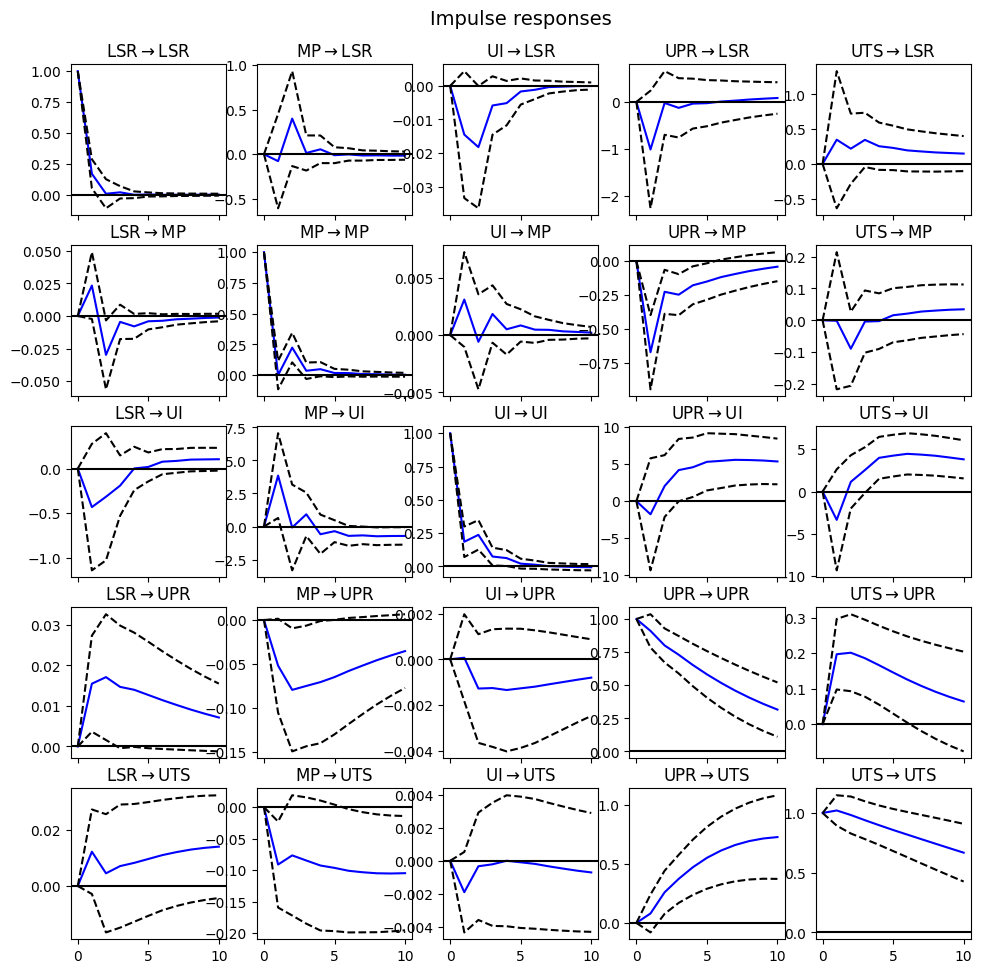

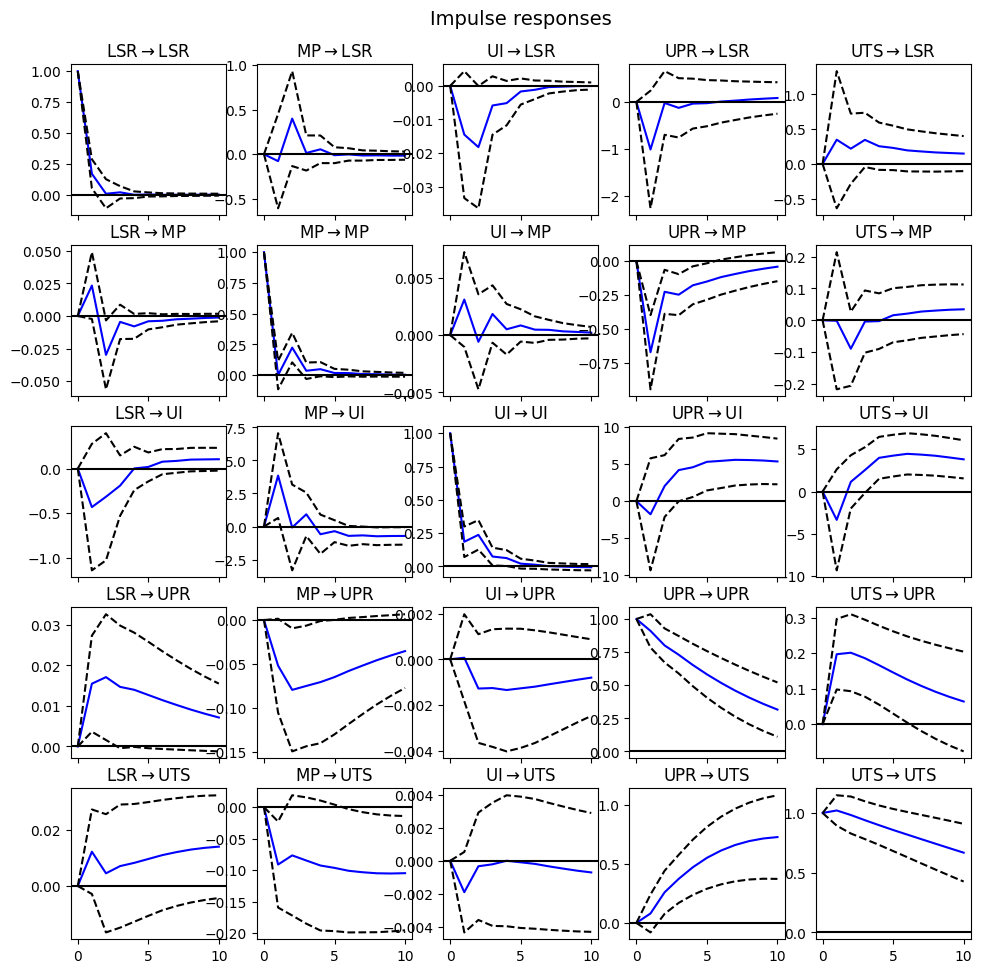

In [380]:
from statsmodels.tsa.api import VAR

VAR_list = [ls_returns, MP, unexpected_inflation, UPR, UTS]
VAR_list = [squeeze if isinstance(squeeze, pd.Series) else squeeze.squeeze() for squeeze in VAR_list]

for s, name in zip(VAR_list, ['LSR','MP', 'UI', 'UPR', 'UTS']):
    s.name = name

VAR_data = pd.concat(VAR_list, axis=1, join="inner").dropna()

model = VAR(VAR_data)
results = model.fit(2)
#results.summary()
irf = results.irf(10)
irf.plot(orth=False)

In [382]:
#Model diagnostics
# Check for autocorrelation (Ljung-Box)
from statsmodels.stats.diagnostic import acorr_ljungbox

for col in results.resid.columns:
    print(f"{col} residuals Ljung-Box p-value:")
    print(acorr_ljungbox(results.resid[col], lags=[10], return_df=True))

# Check for normality
from statsmodels.stats.stattools import jarque_bera
jb = results.test_normality()
print(jb.summary())

#Stability Test
results.is_stable(verbose=True)  # or:
print(results.roots)
print((abs(results.roots) < 1).all())  # should be True


LSR residuals Ljung-Box p-value:
      lb_stat  lb_pvalue
10  10.013202   0.439336
MP residuals Ljung-Box p-value:
      lb_stat  lb_pvalue
10  11.517392   0.318652
UI residuals Ljung-Box p-value:
      lb_stat  lb_pvalue
10  33.796972     0.0002
UPR residuals Ljung-Box p-value:
     lb_stat  lb_pvalue
10  27.21707   0.002406
UTS residuals Ljung-Box p-value:
      lb_stat  lb_pvalue
10  15.301041   0.121466
normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2375.          18.31   0.000 10
----------------------------------------
Eigenvalues of VAR(1) rep
0.911704435547139
0.911704435547139
0.4432350827893552
0.18866740500642212
0.18322549065928076
0.18322549065928076
0.5528429541109509
0.36989363331988845
0.3041406134795509
0.13716548819840427
[ 7.29046361-0.j         -3.97604554+3.73873791j -3.97604554-3.73873

Since not all Eigenvalues are smaller than 1 further measures have to be taken.

- check for stability in each series -> maybe use difference of series
- use VECM and cointegration